In [1]:
! pip install pymongo
! pip install matplotlib seaborn pandas numpy


[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import bson, json
from datetime import datetime
from collections import defaultdict

### Method definition

In [3]:
# Convert bson file to dataframe
def bson_to_dataframe(filename):
    with open(f'./bson/{filename}.bson', 'rb') as f:
        data = bson.decode_all(f.read())
        df = pd.DataFrame(data)
    return df

In [4]:
# Convert json file to dataframe
def json_to_dataframe(filename):
    with open(f'./json/{filename}.json', 'rb') as f:
        data = json.load(f)
        df = pd.DataFrame(data)
    return df

In [5]:
# Calculate duration 
'''
Title: Calculate Time Difference Between Two Pandas Columns in Hours and Minutes
Author: cottontail
Date: Feb 16, 2023
Availability: https://stackoverflow.com/questions/22923775/calculate-time-difference-between-two-pandas-columns-in-hours-and-minutes
'''
def cal_total_time(start_time, end_time):
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    duration = end_time - start_time
    duration_readable = "{:02}:{:02}:{:02}".format(int(duration.seconds / 3600), int((duration.seconds % 3600) / 60), int(duration.seconds % 60))

    return duration_readable

In [6]:
# Extract results of surveys
def extract_survey_results(dataframe):
    results = dataframe['results']

    '''
    Title: Convert Pandas Series to Dict in Python (with code)
    Author: Riddhima Agarwal
    Date: Jun 10, 2023
    Availability: https://favtutor.com/blogs/pandas-series-to-dict#:~:text=A%20Pandas%20Series%20can%20be,the%20Pandas%20Series%20as%20values
    '''
    results_list = results.to_list()
    results_df = pd.DataFrame(results_list)

    dataframe_joined = dataframe.join(results_df)
    columns = ['_id', 'results', 'createdAt', 'updatedAt', '__v']
    dataframe = dataframe_joined.drop(columns=columns, axis=1)

    return dataframe

In [7]:
# Draw heatmap to show level of familiarity, complexity and satisfaction for each user and task
def draw_heatmap(df, selected_column, cmap):
    heatmap_data = df.pivot_table(index='user_id', columns='task_id', values=selected_column, fill_value=0)

    plt.figure(figsize=(6, 3))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=cmap, linewidths=.5)
    plt.title(f'{selected_column} heatmap')
    plt.xlabel('Task ID')
    plt.ylabel('User ID')

### Data Exploration

In [8]:
users_df = bson_to_dataframe("users")
prestudies_df = bson_to_dataframe("prestudies")
pretasks_df = bson_to_dataframe("pretasks")
sessions_df = bson_to_dataframe("sessions")
searchinteractions_df = bson_to_dataframe("searchinteractions")
documents_df = bson_to_dataframe("documents")
chatinteractions_df = bson_to_dataframe("chatinteractions")
posttasks_df = bson_to_dataframe("posttasks")
poststudies_df = bson_to_dataframe("poststudies")

tasks_df = json_to_dataframe("tasks")

In [9]:
users_df['study_total_time'] = users_df.apply(lambda row: cal_total_time(row['study_start_time'], row['study_end_time']), axis=1)
users_df = users_df[['user_id', 'study_total_time']]
users_df

,user_id,study_total_time
0,557fef0a-6839-4000-aa63-d893e24b8536,00:19:22
1,0122fc9e-4674-4d34-ac15-ea13d0a9e037,00:15:30


### Data Analysis

#### 1. System experience

In [10]:
prestudies_df = extract_survey_results(prestudies_df)
prestudies_df

,user_id,search-engine-usage,Ai-copilots-usage,onl-search-freq,ai-search-freq
0,557fef0a-6839-4000-aa63-d893e24b8536,7,6,Multiple times per day,Multiple times per week
1,0122fc9e-4674-4d34-ac15-ea13d0a9e037,5,3,Multiple times per day,Multiple times per week


#### 2. Pre-Task Data Analysis

##### Topical Familiarity

In [11]:
pretasks_df = extract_survey_results(pretasks_df)
pretasks_df

,user_id,task_id,familiarity,complexity
0,557fef0a-6839-4000-aa63-d893e24b8536,task4,3,6
1,557fef0a-6839-4000-aa63-d893e24b8536,task1,2,2
2,557fef0a-6839-4000-aa63-d893e24b8536,task3,3,6
3,557fef0a-6839-4000-aa63-d893e24b8536,task2,4,3
4,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task1,2,3
5,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task2,2,3
6,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task4,3,5
7,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task3,3,5


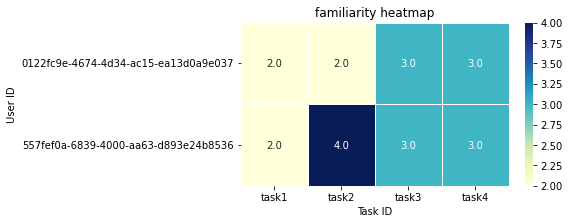

In [12]:
familiarity_heatmap = draw_heatmap(df=pretasks_df, selected_column='familiarity', cmap='YlGnBu')

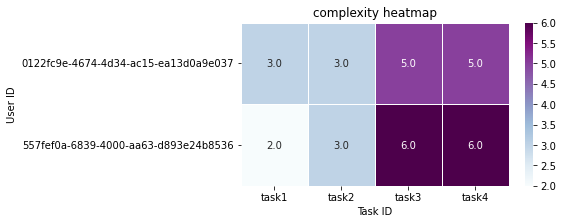

In [13]:
pre_complexity_heatmap = draw_heatmap(df=pretasks_df, selected_column='complexity', cmap='BuPu')

#### 3. Post-Task Data Analysis

In [14]:
posttasks_df = extract_survey_results(posttasks_df)
posttasks_df

,user_id,task_id,answer,complexity-rate,result-system,satisfaction-rate,attention
0,557fef0a-6839-4000-aa63-d893e24b8536,task4,Issues of conventional methods of home heating...,7,Generative AI (ChatGPT),6,Yes
1,557fef0a-6839-4000-aa63-d893e24b8536,task1,"when you are overweight, eat too much salt and...",2,Normal search engine (Google),6,Yes
2,557fef0a-6839-4000-aa63-d893e24b8536,task3,"1. Aspartame, 2. Sodium benzoate, 3. Monosodiu...",6,Generative AI (ChatGPT),7,Yes
3,557fef0a-6839-4000-aa63-d893e24b8536,task2,Bullet ant,1,Normal search engine (Google),7,Yes
4,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task1,"Because of unhealthy lifestyle choices, such a...",1,Normal search engine (Google),5,Yes
5,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task2,The Bulldog Ant,1,Normal search engine (Google),7,Yes
6,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task4,Drawbacks of fossil energy: Fossil fuels pollu...,6,Both Google and ChatGPT,6,Yes
7,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task3,"1. Artificial sweeteners (e.g. aspartame, sacc...",7,Generative AI (ChatGPT),6,Yes


##### 3.1 Task complexity ratings

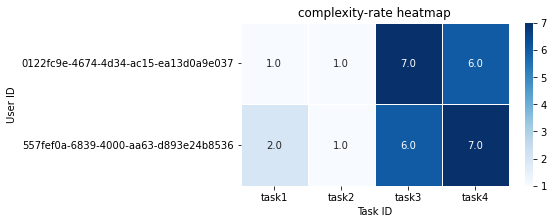

In [15]:
post_complexity_heatmap = draw_heatmap(df=posttasks_df, selected_column='complexity-rate', cmap='Blues')

##### 3.2 Satisfaction ratings

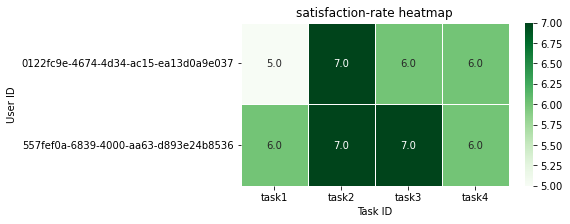

In [16]:
satisfaction_heatmap = draw_heatmap(df=posttasks_df, selected_column='satisfaction-rate', cmap='Greens')

##### 3.3 Answers for evaluation

In [17]:
answers_data = posttasks_df[['user_id', 'task_id', 'answer']]
answers_data

,user_id,task_id,answer
0,557fef0a-6839-4000-aa63-d893e24b8536,task4,Issues of conventional methods of home heating...
1,557fef0a-6839-4000-aa63-d893e24b8536,task1,"when you are overweight, eat too much salt and..."
2,557fef0a-6839-4000-aa63-d893e24b8536,task3,"1. Aspartame, 2. Sodium benzoate, 3. Monosodiu..."
3,557fef0a-6839-4000-aa63-d893e24b8536,task2,Bullet ant
4,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task1,"Because of unhealthy lifestyle choices, such a..."
5,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task2,The Bulldog Ant
6,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task4,Drawbacks of fossil energy: Fossil fuels pollu...
7,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task3,"1. Artificial sweeteners (e.g. aspartame, sacc..."


In [18]:
# get the answer for task 3 of user HP1 
filtered_data = answers_data[(answers_data['user_id'] == '557fef0a-6839-4000-aa63-d893e24b8536') & (answers_data['task_id'] == 'task3')]
answer = filtered_data['answer'].values[0] if not filtered_data.empty else None
answer

'1. Aspartame, 2. Sodium benzoate, 3. Monosodium glutamate (MSG), 4. Carrageenan, 5. Butylated hydroxytoluene (BHT), 6. Propyl gallate\n7. Sorbic acid, 8. Potassium sorbate, 9. Ascorbic acid, 10. Sodium nitrate'

#### 4 Demographic Data

In [19]:
poststudies_df = extract_survey_results(poststudies_df)
poststudies_df

,user_id,gender,age,qualification,occupation,enjoy,Vp-stunden,matrikel-nr
0,557fef0a-6839-4000-aa63-d893e24b8536,Female,24,High school diploma or equivalent degree,Student,"Yes, so informative",True,abc1234
1,0122fc9e-4674-4d34-ac15-ea13d0a9e037,Male,30,Master’s degree,Engineer,Yes,False,NaN


In [20]:
# filter only participants who need VP-Stunden
VP_data = poststudies_df[(poststudies_df['Vp-stunden'] == True)]
matrikel_nr_list = VP_data['matrikel-nr']
matrikel_nr_list

'''
Title: Writing a list to a file with Python, with newlines
Author: Alex Martelli
Date: May 22, 2009
Availability: https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python-with-newlines
'''
with open('matrikel_nr_list.txt', 'w') as f:
    for line in matrikel_nr_list:
        f.write(f"{line}\n")

#### 5 Interaction Data Analysis

In [21]:
tasks_df.rename(columns={'id':'task_id'}, inplace=True)
tasks_df

,title,category,desc,task_id
0,Task 1:,simple,Your brother complains of constant headaches. ...,task1
1,Task 2:,simple,A friend has just sent an email from an Intern...,task2
2,Task 3:,complex,"You recently heard about the book ""Fast Food N...",task3
3,Task 4:,complex,Friends are planning to build a new house and ...,task4


In [22]:
sessions_df['session_total_time'] = sessions_df.apply(lambda row: cal_total_time(row['session_start_time'], row['session_end_time']), axis=1)
columns = ['_id', '__v', 'session_start_time', 'session_end_time']
sessions_df = sessions_df.drop(columns=columns, axis=1)

In [23]:
sessions_df

,session_id,user_id,task_id,session_total_time
0,a5cade73-3dd6-4d38-819e-16a4a116a198,557fef0a-6839-4000-aa63-d893e24b8536,task4,00:05:19
1,8b307c17-753f-45d5-ad56-129ac7904fb0,557fef0a-6839-4000-aa63-d893e24b8536,task1,00:01:16
2,6ea3ced1-943b-4e01-a6a0-b97162138c73,557fef0a-6839-4000-aa63-d893e24b8536,task3,00:01:16
3,1eb8ec0e-050d-445e-be91-cbcc0b97de25,557fef0a-6839-4000-aa63-d893e24b8536,task2,00:00:35
4,406061dc-10cd-4b24-adbf-31db4fecdd9d,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task1,00:01:01
5,c330ad5e-0992-4e1c-a08c-f7c4aa5cbc05,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task2,00:01:51
6,17813491-6f12-4ca1-8fc7-7f724ead5abe,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task4,00:04:20
7,d4463320-3008-4878-8a72-f3f53940ca26,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task3,00:00:46


##### 5.1 Time overall

In [24]:
sessions_merged_df= pd.merge(sessions_df, tasks_df, on='task_id', how='left')
sessions_merged_df = sessions_merged_df.drop(['title', 'desc'], axis=1)

In [25]:
sessions_merged_df 

,session_id,user_id,task_id,session_total_time,category
0,a5cade73-3dd6-4d38-819e-16a4a116a198,557fef0a-6839-4000-aa63-d893e24b8536,task4,00:05:19,complex
1,8b307c17-753f-45d5-ad56-129ac7904fb0,557fef0a-6839-4000-aa63-d893e24b8536,task1,00:01:16,simple
2,6ea3ced1-943b-4e01-a6a0-b97162138c73,557fef0a-6839-4000-aa63-d893e24b8536,task3,00:01:16,complex
3,1eb8ec0e-050d-445e-be91-cbcc0b97de25,557fef0a-6839-4000-aa63-d893e24b8536,task2,00:00:35,simple
4,406061dc-10cd-4b24-adbf-31db4fecdd9d,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task1,00:01:01,simple
5,c330ad5e-0992-4e1c-a08c-f7c4aa5cbc05,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task2,00:01:51,simple
6,17813491-6f12-4ca1-8fc7-7f724ead5abe,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task4,00:04:20,complex
7,d4463320-3008-4878-8a72-f3f53940ca26,0122fc9e-4674-4d34-ac15-ea13d0a9e037,task3,00:00:46,complex


In [26]:
task_time_df = sessions_merged_df[['task_id', 'session_total_time']]
task_time_df

,task_id,session_total_time
0,task4,00:05:19
1,task1,00:01:16
2,task3,00:01:16
3,task2,00:00:35
4,task1,00:01:01
5,task2,00:01:51
6,task4,00:04:20
7,task3,00:00:46


In [27]:
# calculate the overall time for each task
def cal_time_each_task(dataframe):
    task_time_list = dataframe.to_dict('records')

    task_time_dict = {}

    for entry in task_time_list:
        task_id = entry["task_id"]
        session_time = datetime.strptime(entry["session_total_time"], "%H:%M:%S")
        if task_id in task_time_dict:
            task_time_dict[task_id] += session_time - datetime(1900, 1, 1)
        else:
            task_time_dict[task_id] = session_time - datetime(1900, 1, 1)

    return task_time_dict

In [28]:
# Visualization using bar chart
'''
Title: Bar Plot in Matplotlib
Author: jeeteshgavand
Date: 04 Mar, 2021
Availability: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
'''
def visualize_time_each_task(task_time_dict):
    # Figure Size
    fig, ax = plt.subplots(figsize =(8, 3))
    
    task_overalltime_minutes = {key: value.total_seconds()/60 for key, value in task_time_dict.items()}

    tasks = list(task_overalltime_minutes.keys())
    minutes = list(task_overalltime_minutes.values())
    # Horizontal Bar Plot
    ax.barh(tasks, minutes)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values 
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')
    
        # Adding labels and title
    ax.set_xlabel('Minutes')
    ax.set_title('Overall Time for each Task',
                loc ='left', )

In [29]:
def visualize_overalltime(task_time_dict): 
    simple_tasks_overalltime = (task_time_dict['task1'] + task_time_dict['task2']).total_seconds()/60
    complex_tasks_overalltime =(task_time_dict['task3'] + task_time_dict['task4']).total_seconds()/60

    # Data for plotting
    tasks = ['Simple Tasks', 'Complex Tasks']
    times = [simple_tasks_overalltime, complex_tasks_overalltime]

    fig = plt.figure(figsize = (5, 3))

    # Plotting the bar chart
    plt.bar(tasks, times, color ='maroon')

    # Adding labels and title
    plt.xlabel('Task Type')
    plt.ylabel('Overall Time (minutes)')
    plt.title('Overall Time for Simple vs Complex Tasks')

In [30]:
# calculate the overall time for each type of tasks
def print_overalltime(task_time_dict):
    
    # Convert total times to string format
    simple_tasks_overalltime = str(task_time_dict['task1'] + task_time_dict['task2'])
    complex_tasks_overalltime = str(task_time_dict['task3'] + task_time_dict['task4'])

    for task_id, total_time in task_time_dict.items():
        task_time_dict[task_id] = str(total_time)

    # print overalltime
    print("Overall time for each task:")
    for task_id, total_time in task_time_dict.items():
        print(f"{task_id}: {total_time}")

    print('Overall time for simple tasks: ' + simple_tasks_overalltime)
    print('Overall time for complex tasks: ' + complex_tasks_overalltime)

Overall time for each task:
task4: 0:09:39
task1: 0:02:17
task3: 0:02:02
task2: 0:02:26
Overall time for simple tasks: 0:04:43
Overall time for complex tasks: 0:11:41


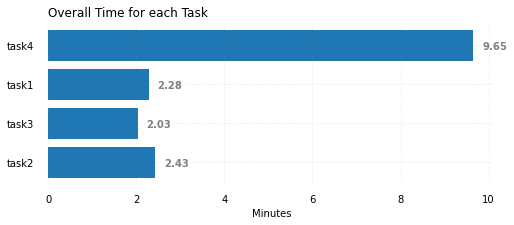

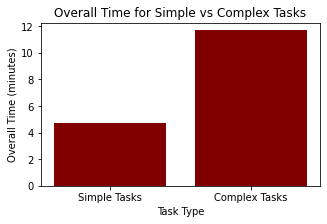

In [31]:
task_overalltime = cal_time_each_task(task_time_df)
visualize_time_each_task(task_overalltime)
visualize_overalltime(task_overalltime)
print_overalltime(task_overalltime)

##### 5.2 Queries

1. Search Queries

In [32]:
# Count number of queries each task when interacting with SE or Chat
def count_queries_each_task(dict):
    queries_counts = defaultdict(int)

    for item in dict:
        queries_counts[item['task_id']] += 1

    return queries_counts

In [33]:
task_session_df = sessions_merged_df[['session_id', 'task_id']]
task_session_df 

,session_id,task_id
0,a5cade73-3dd6-4d38-819e-16a4a116a198,task4
1,8b307c17-753f-45d5-ad56-129ac7904fb0,task1
2,6ea3ced1-943b-4e01-a6a0-b97162138c73,task3
3,1eb8ec0e-050d-445e-be91-cbcc0b97de25,task2
4,406061dc-10cd-4b24-adbf-31db4fecdd9d,task1
5,c330ad5e-0992-4e1c-a08c-f7c4aa5cbc05,task2
6,17813491-6f12-4ca1-8fc7-7f724ead5abe,task4
7,d4463320-3008-4878-8a72-f3f53940ca26,task3


In [34]:
cols = ['_id', '__v', 'createdAt', 'updatedAt']
searchinteractions_df = searchinteractions_df.drop(columns=cols, axis=1)
documents_df = documents_df.drop(columns=cols, axis=1)

In [35]:
googlesearch_merged_df = pd.merge(searchinteractions_df, task_session_df, on='session_id', how='inner')
googlesearch_merged_df.head(10)

,interaction_id,user_id,session_id,interaction_type,query,number_of_retrieved_docs,task_id
0,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources,"127,000,000",task4
1,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources home heating,"51,500,000",task4
2,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues solar panels home heating,"207,000,000",task4
3,8ff4cdd3-65bc-4738-8c44-9dba3078423f,557fef0a-6839-4000-aa63-d893e24b8536,8b307c17-753f-45d5-ad56-129ac7904fb0,google,reasons of high blood pressure,"1,480,000,000",task1
4,2203bcc5-b4f5-4bdc-9af4-b86fe400c9cf,557fef0a-6839-4000-aa63-d893e24b8536,1eb8ec0e-050d-445e-be91-cbcc0b97de25,google,one specie of dangerous ant,"12,300,000",task2
5,b4cf493e-15e3-477d-b3aa-e12d41bc59eb,0122fc9e-4674-4d34-ac15-ea13d0a9e037,406061dc-10cd-4b24-adbf-31db4fecdd9d,google,what causes high blood pressure,"1,150,000,000",task1
6,6c7b5317-3648-462f-8ce9-33dc0787bbb3,0122fc9e-4674-4d34-ac15-ea13d0a9e037,c330ad5e-0992-4e1c-a08c-f7c4aa5cbc05,google,Name one specie of ant,"73,000,000",task2
7,6c7b5317-3648-462f-8ce9-33dc0787bbb3,0122fc9e-4674-4d34-ac15-ea13d0a9e037,c330ad5e-0992-4e1c-a08c-f7c4aa5cbc05,google,Name one specie of dangerous ant,"18,900,000",task2
8,d08655ac-e7c2-4d17-925a-2b8c168243fc,0122fc9e-4674-4d34-ac15-ea13d0a9e037,17813491-6f12-4ca1-8fc7-7f724ead5abe,google,disadvantages of fossil energy sources,"55,500,000",task4
9,d08655ac-e7c2-4d17-925a-2b8c168243fc,0122fc9e-4674-4d34-ac15-ea13d0a9e037,17813491-6f12-4ca1-8fc7-7f724ead5abe,google,drawbacks of solar panels,"9,550,000",task4


In [36]:
task_queries_SE_df = googlesearch_merged_df[['query', 'task_id']]
task_queries_SE_df

,query,task_id
0,issues fossil energy sources,task4
1,issues fossil energy sources home heating,task4
2,issues solar panels home heating,task4
3,reasons of high blood pressure,task1
4,one specie of dangerous ant,task2
5,what causes high blood pressure,task1
6,Name one specie of ant,task2
7,Name one specie of dangerous ant,task2
8,disadvantages of fossil energy sources,task4
9,drawbacks of solar panels,task4


In [37]:
task_queries_SE_dict = task_queries_SE_df.to_dict('records')
task_queries_SE_dict

[{'query': 'issues fossil energy sources', 'task_id': 'task4'},
 {'query': 'issues fossil energy sources  home heating', 'task_id': 'task4'},
 {'query': 'issues solar panels home heating', 'task_id': 'task4'},
 {'query': 'reasons of high blood pressure', 'task_id': 'task1'},
 {'query': 'one specie of dangerous ant', 'task_id': 'task2'},
 {'query': 'what causes high blood pressure', 'task_id': 'task1'},
 {'query': 'Name one specie of ant', 'task_id': 'task2'},
 {'query': 'Name one specie of dangerous ant', 'task_id': 'task2'},
 {'query': 'disadvantages of fossil energy sources', 'task_id': 'task4'},
 {'query': 'drawbacks of solar panels', 'task_id': 'task4'}]

2. Chat Queries

In [38]:
chatinteractions_df = chatinteractions_df[['user_id', 'session_id', 'interaction_type', 'messages']]
chatinteractions_df

,user_id,session_id,interaction_type,messages
0,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,openai,[[{'text': 'do some research to identify some ...
1,557fef0a-6839-4000-aa63-d893e24b8536,8b307c17-753f-45d5-ad56-129ac7904fb0,openai,"[[{'text': 'what causes high blood pressure?',..."
2,557fef0a-6839-4000-aa63-d893e24b8536,6ea3ced1-943b-4e01-a6a0-b97162138c73,openai,[[{'text': 'which food additives pose a risk t...
3,557fef0a-6839-4000-aa63-d893e24b8536,1eb8ec0e-050d-445e-be91-cbcc0b97de25,openai,None
4,0122fc9e-4674-4d34-ac15-ea13d0a9e037,406061dc-10cd-4b24-adbf-31db4fecdd9d,openai,[[{'text': 'Your brother complains of constant...
5,0122fc9e-4674-4d34-ac15-ea13d0a9e037,c330ad5e-0992-4e1c-a08c-f7c4aa5cbc05,openai,"[[{'text': 'one specie of dangerous ant', 'isB..."
6,0122fc9e-4674-4d34-ac15-ea13d0a9e037,17813491-6f12-4ca1-8fc7-7f724ead5abe,openai,[[{'text': 'Friends are planning to build a ne...
7,0122fc9e-4674-4d34-ac15-ea13d0a9e037,d4463320-3008-4878-8a72-f3f53940ca26,openai,[[{'text': 'You recently heard about the book ...


In [39]:
chat_merged_df = pd.merge(chatinteractions_df, task_session_df, on='session_id', how='inner')
chat_merged_df.head(10)

,user_id,session_id,interaction_type,messages,task_id
0,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,openai,[[{'text': 'do some research to identify some ...,task4
1,557fef0a-6839-4000-aa63-d893e24b8536,8b307c17-753f-45d5-ad56-129ac7904fb0,openai,"[[{'text': 'what causes high blood pressure?',...",task1
2,557fef0a-6839-4000-aa63-d893e24b8536,6ea3ced1-943b-4e01-a6a0-b97162138c73,openai,[[{'text': 'which food additives pose a risk t...,task3
3,557fef0a-6839-4000-aa63-d893e24b8536,1eb8ec0e-050d-445e-be91-cbcc0b97de25,openai,None,task2
4,0122fc9e-4674-4d34-ac15-ea13d0a9e037,406061dc-10cd-4b24-adbf-31db4fecdd9d,openai,[[{'text': 'Your brother complains of constant...,task1
5,0122fc9e-4674-4d34-ac15-ea13d0a9e037,c330ad5e-0992-4e1c-a08c-f7c4aa5cbc05,openai,"[[{'text': 'one specie of dangerous ant', 'isB...",task2
6,0122fc9e-4674-4d34-ac15-ea13d0a9e037,17813491-6f12-4ca1-8fc7-7f724ead5abe,openai,[[{'text': 'Friends are planning to build a ne...,task4
7,0122fc9e-4674-4d34-ac15-ea13d0a9e037,d4463320-3008-4878-8a72-f3f53940ca26,openai,[[{'text': 'You recently heard about the book ...,task3


In [40]:
def extract_chat_queries():  
    task_query_AI_dict = chat_merged_df[['messages', 'task_id']].to_dict() 
    extracted_data = []
    for key, value in task_query_AI_dict['messages'].items():
        if value is not None:
            for task_id, sublist in enumerate(value):
                for message in sublist:
                    if not message['isBot']:
                        extracted_data.append({'task_id': task_query_AI_dict['task_id'][key], 'query': message['text']})
    return extracted_data

In [41]:
task_queries_AI_dict = extract_chat_queries()
task_queries_AI_dict

[{'task_id': 'task4',
  'query': 'do some research to identify some issues that need to be considered in deciding between more conventional methods of home heating (fossil energy sources) and solar panels.'},
 {'task_id': 'task4',
  'query': 'issues of fossil energy sources home heating\n'},
 {'task_id': 'task1', 'query': 'what causes high blood pressure?'},
 {'task_id': 'task3',
  'query': 'which food additives pose a risk to your physical health, and are likely to be listed on grocery store labels.'},
 {'task_id': 'task3',
  'query': 'I want a only a list of name of food additives'},
 {'task_id': 'task1',
  'query': 'Your brother complains of constant headaches. One night when his headache is accompanied by nausea, you go to the medical center with him and find out that his blood pressure is 120. You want to know: what causes high blood pressure?'},
 {'task_id': 'task1', 'query': 'i want a list'},
 {'task_id': 'task2', 'query': 'one specie of dangerous ant'},
 {'task_id': 'task4',
  

In [42]:
task_queries_AI_df = pd.DataFrame(task_queries_AI_dict)
task_queries_AI_df 

,task_id,query
0,task4,do some research to identify some issues that ...
1,task4,issues of fossil energy sources home heating\n
2,task1,what causes high blood pressure?
3,task3,which food additives pose a risk to your physi...
4,task3,I want a only a list of name of food additives
5,task1,Your brother complains of constant headaches. ...
6,task1,i want a list
7,task2,one specie of dangerous ant
8,task4,Friends are planning to build a new house and ...
9,task4,I want the answer in a shorter text


3. Number of queries each system

In [43]:
queries_SE_counts = count_queries_each_task(task_queries_SE_dict)
queries_SE_counts_df = pd.DataFrame(list(queries_SE_counts .items()), columns=['Task ID', 'Num Queries SE'])
queries_SE_counts_df

,Task ID,Num Queries SE
0,task4,5
1,task1,2
2,task2,3


In [44]:
queries_AI_counts = count_queries_each_task(task_queries_AI_dict)
queries_AI_counts_df = pd.DataFrame(list(queries_AI_counts .items()), columns=['Task ID', 'Num Queries AI'])
queries_AI_counts_df

,Task ID,Num Queries AI
0,task4,5
1,task1,3
2,task3,4
3,task2,1


In [45]:
queries_system_df = pd.merge(queries_AI_counts_df, queries_SE_counts_df, on='Task ID', how='outer')
queries_system_df

,Task ID,Num Queries AI,Num Queries SE
0,task4,5,5.0
1,task1,3,2.0
2,task3,4,NaN
3,task2,1,3.0


4. Mean query length each system

In [46]:
def cal_mean_query_length (dict, system):
    # Dictionary to store total query length and count for each task
    task_lengths = defaultdict(lambda: {'total_length': 0, 'count': 0})

    # Calculate total query length and count for each task
    for query in dict:
        task_id = query['task_id']
        query_length = len(query['query'].split())  # Split query by space and count words
        task_lengths[task_id]['total_length'] += query_length
        task_lengths[task_id]['count'] += 1

    # Calculate mean query length for each task
    mean_lengths = {task_id: task_info['total_length'] / task_info['count'] for task_id, task_info in task_lengths.items()}

    df = pd.DataFrame(mean_lengths.items(), columns=['Task ID', f"Mean Length Query{system}"])
    return df

In [47]:
mean_length_queryAI_df = cal_mean_query_length(task_queries_AI_dict, "AI")
mean_length_queryAI_df

,Task ID,Mean Length QueryAI
0,task4,29.000000
1,task1,16.666667
2,task3,27.750000
3,task2,5.000000


In [48]:
mean_length_querySE_df = cal_mean_query_length(task_queries_SE_dict, "SE")
mean_length_querySE_df

,Task ID,Mean Length QuerySE
0,task4,4.800000
1,task1,5.000000
2,task2,5.333333


In [49]:
mean_query_length_df = pd.merge(mean_length_queryAI_df, mean_length_querySE_df, on='Task ID', how='outer')
mean_query_length_df

,Task ID,Mean Length QueryAI,Mean Length QuerySE
0,task4,29.000000,4.800000
1,task1,16.666667,5.000000
2,task3,27.750000,NaN
3,task2,5.000000,5.333333


5. Visualization 

In [50]:
# Visualize using multiple bar charts
'''
Title: Bar Plot in Matplotlib
Author: jeeteshgavand
Date: 04 Mar, 2021
Availability: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
'''
def visualize(df, col1, col2, ylabel): 
    barWidth = 0.25
    fig = plt.subplots(figsize =(6, 3)) 

    list1 = df[col1]
    list2 = df[col2]
    
    br1 = np.arange(len(list1)) 
    br2 = [x + barWidth for x in br1] 
    
    plt.bar(br1, list1, color ='r', width = barWidth, 
            edgecolor ='grey', label =col1) 
    plt.bar(br2, list2, color ='g', width = barWidth, 
            edgecolor ='grey', label =col2) 

    plt.xlabel('Task ID', fontsize = 15) 
    plt.ylabel( ylabel, fontsize = 15) 
    plt.xticks([r + barWidth for r in range(len(list1))], df['Task ID'])
    
    plt.legend()

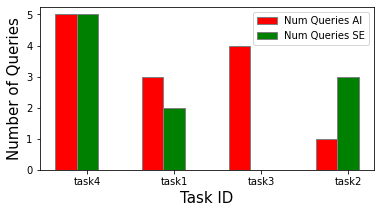

In [51]:
num_Queries_AI ='Num Queries AI'
num_Queries_SE ='Num Queries SE'
yLabel1 = "Number of Queries"
visualize(queries_system_df, num_Queries_AI, num_Queries_SE, yLabel1)

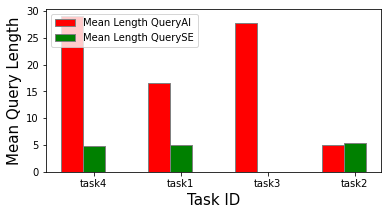

In [52]:
mean_length_AI = "Mean Length QueryAI"
mean_length_SE = "Mean Length QuerySE"
yLabel2 = "Mean Query Length"
visualize(mean_query_length_df, mean_length_AI, mean_length_SE, yLabel2)

##### 5.3 Doc position analysis

In [53]:
googlesearch_docs_df = pd.merge(googlesearch_merged_df, documents_df, on='interaction_id', how='inner')
googlesearch_docs_df.head(10)

,interaction_id,user_id,session_id,interaction_type,query,number_of_retrieved_docs,task_id,doc_id,doc_title,doc_position,doc_page_viewed
0,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources,"127,000,000",task4,DNDuuB7XFFQJ,Fossil Fuels: The Dirty Facts,1,1
1,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources,"127,000,000",task4,JFterFwuzeEJ,"Fact Sheet | Climate, Environmental, and Healt...",3,1
2,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources,"127,000,000",task4,FCCGX17YItkJ,Natural gas and the environment - U.S. Energy ...,3,2
3,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources,"127,000,000",task4,3HRh1i2D9gYJ,The Pros and Cons Of Solar Energy (2024 Guide)...,7,1
4,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources home heating,"51,500,000",task4,DNDuuB7XFFQJ,Fossil Fuels: The Dirty Facts,1,1
5,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources home heating,"51,500,000",task4,JFterFwuzeEJ,"Fact Sheet | Climate, Environmental, and Healt...",3,1
6,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources home heating,"51,500,000",task4,FCCGX17YItkJ,Natural gas and the environment - U.S. Energy ...,3,2
7,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues fossil energy sources home heating,"51,500,000",task4,3HRh1i2D9gYJ,The Pros and Cons Of Solar Energy (2024 Guide)...,7,1
8,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues solar panels home heating,"207,000,000",task4,DNDuuB7XFFQJ,Fossil Fuels: The Dirty Facts,1,1
9,671330bf-7d9a-4e40-a581-cdd654aefd55,557fef0a-6839-4000-aa63-d893e24b8536,a5cade73-3dd6-4d38-819e-16a4a116a198,google,issues solar panels home heating,"207,000,000",task4,JFterFwuzeEJ,"Fact Sheet | Climate, Environmental, and Healt...",3,1
